In [1]:
import sys
sys.path.insert(0, '..')

import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
import matplotlib.pyplot as plt
import measure_metric.measureMetric as measureMetric

from stencilgen.stencil import *
from tsmgen.kernel import *
import stencilgen.bench as stencilbench
import tsmgen.benchmark as tsmbench
from predict import *

#% matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stencilgen.stencil
%aimport stencilgen.bench
%aimport predict

In [3]:
storeVolumes = []
loadVolumes = []
for r in range(1, 10):
    kernel = Kernel2DBoxStencil(stencil_range=r, l1only=False)
    
    measureMetric.measureBandwidthStart()
    block = (32, 8, 1)
    stencilbench.runKernel(kernel, kernel.getGrid(1, block, 15000, 15000), block)
    result = measureMetric.measureMetricStop()
    
    storeVolumes.append(result[1])
    loadVolumes.append(result[0])
    print("mem load: " + str(result[0] / 15000**2))
    print("mem store: " + str(result[1] / 15000**2))
    print("L2  load: " + str(result[2]*32 / 15000**2))
    print("L2  store: " + str(result[3]*32 / 15000**2))
    L2CLs, L1CLs = computeCacheVolumes(kernel, 32, block, (1,1,1))
    
    print("pred L1 CLs: " + str(len(L1CLs)))
    print("pred L2 volume: " + str(L2CLs * 32 / block[0] / block[1] / block[2]))
    print()

mem load: 8.005269475555556
mem store: 7.985205902222222
L2  load: 12.459802595555555
L2  store: 8.003195306666667
pred L1 CLs: 72
pred L2 volume: 12.5

mem load: 8.004489244444445
mem store: 7.984673848888889
L2  load: 14.895393706666667
L2  store: 8.002129493333333
pred L1 CLs: 200
pred L2 volume: 15.0

mem load: 8.004401635555556
mem store: 7.9836983466666664
L2  load: 17.383110257777776
L2  store: 8.001062968888888
pred L1 CLs: 392
pred L2 volume: 17.5

mem load: 8.000199537777778
mem store: 7.978871751111111
L2  load: 19.84053489777778
L2  store: 7.991473777777777
pred L1 CLs: 648
pred L2 volume: 20.0

mem load: 8.004408746666666
mem store: 7.978168604444445
L2  load: 26.605094826666665
L2  store: 7.994664675555556
pred L1 CLs: 968
pred L2 volume: 27.0

mem load: 8.004416426666667
mem store: 7.977803946666667
L2  load: 29.487000604444443
L2  store: 7.993598862222222
pred L1 CLs: 1352
pred L2 volume: 30.0

mem load: 8.004512568888888
mem store: 7.977399893333334
L2  load: 32.284524

In [4]:
def compareSeries( xblocks, yblocks, ranges, **stencilArgs):
    best_values = []

    measuredValues = []
    predictedValues = []
   
    xtickCounter = 0
    xticks = []
    xtickLabels = []

    for r in ranges:
        kernel = Kernel2DBoxStencil(stencil_range=r, **stencilArgs)
    
        for xblock in xblocks:
            
            newXtick = xtickCounter
            newLabel = "r={};{}xY".format(r, xblock)

            for yblock in yblocks:
                if xblock*yblock > 1024 or xblock*yblock < 64:
                    continue

                block = (xblock, yblock, 1)

                print("r={}, block={}x{}".format(r, xblock, yblock))
                measuredValues.append( stencilbench.benchKernel(kernel, 11, (xblock, yblock, 1))[2])
                predictedValues.append(predictPerformance(kernel, block, (1,1,1), 32) )
                print("Meas / Pred (GFlop/s): {:.0f} / {:.0f}".format( measuredValues[-1], predictedValues[-1]))
                print()
                xtickCounter += 1
                
            if newXtick != xtickCounter:
                xticks.append(newXtick)
                xtickLabels.append(newLabel)        

        print()
    return measuredValues, predictedValues, xticks, xtickLabels

def plotComparison(measuredValues, predictedValues, xticks, xtickLabels):
    fig, ax = plt.subplots()
    fig.set_figwidth(9)
    fig.set_figheight(4.5)
    fig.set_dpi(200)

    ax.plot(predictedValues, "-+", label="predicted",  color="#CCE699", linewidth=3, markersize=9, markeredgewidth=2, markeredgecolor="#B5CC88")
    ax.plot(measuredValues, "-x", label="measured", color="#99B3E6", linewidth=3, markersize=7, markeredgewidth=2, markeredgecolor="#889FCC")

    #ax.set_yscale("log")

    ax.set_xticks(xticks)
    ax.set_xticklabels( xtickLabels, rotation=60, rotation_mode="anchor", horizontalalignment="right")
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlim(-1, len(predictedValues))

    fig.tight_layout()
    ax.legend()
    ax.grid()
    plt.show()


In [5]:
l1data = compareSeries([ 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,1024], [4], l1only=True)

r=4, block=2x32
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1067   21888  5184        0       0  28075
       5120   200   38456   648        0       0  43776
Meas / Pred (GFlop/s): 278 / 418

r=4, block=2x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1067   10944  5184        0       0  14571
       2560   200   41016   648        0       0  43776
Meas / Pred (GFlop/s): 275 / 418

r=4, block=2x128
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1067    5472  5184        0       0   7819
       1280   200   42296   648        0       0  43776
Meas / Pred (GFlop/s): 275 / 418

r=4, block=2x256
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1067    2736  5184        0       0   6891
        640   200   42936   648        0       0  43776
Meas / Pred (GFlop/s): 276 / 418

r=4, block=2x512
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1067    1368  5184        0       0   65

Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1067     324  5184        0       0   6571
        320   200    9848   648        0       0  10368
Meas / Pred (GFlop/s): 1484 / 1766

r=4, block=1024x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1067     324  5184        0       0   6571
        320   200    9848   648        0       0  10368
Meas / Pred (GFlop/s): 1479 / 1766




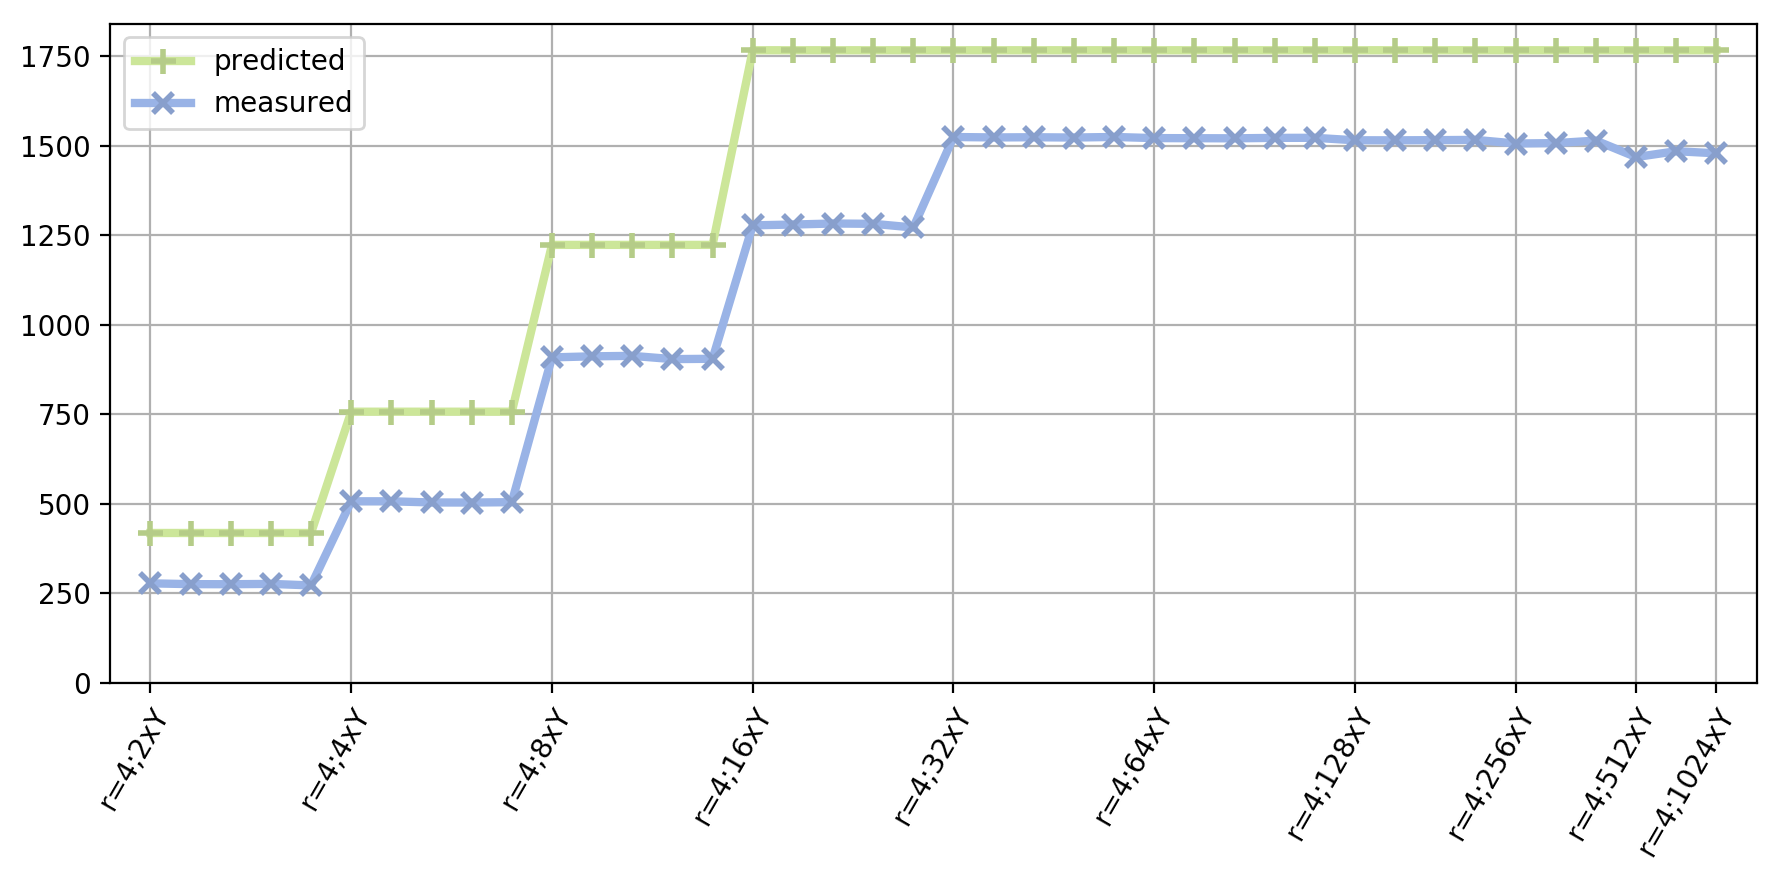

In [6]:
plotComparison(*l1data)

In [7]:
memdata = compareSeries([ 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256], [1, 3, 7])

r=1, block=2x32
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1067    2688   576     4638    6331  19843
       5120   200      84    72      271     656   6331
Meas / Pred (GFlop/s): 187 / 321

r=1, block=2x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1067    1344   576     4638    6180  15789
       2560   200      84    72      271    3065   6180
Meas / Pred (GFlop/s): 184 / 329

r=1, block=2x128
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1067     672   576     4638    6105  13761
       1280   200      84    72      271    4270   6105
Meas / Pred (GFlop/s): 178 / 333

r=1, block=2x256
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1067     336   576     4638    6067  12988
        640   200      84    72      271    4872   6067
Meas / Pred (GFlop/s): 153 / 335

r=1, block=4x16
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1067    1344   576     4638    5276  1744

Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1067      36   576     4638    4852  11452
        320   200      18    72      271    3989   4852
Meas / Pred (GFlop/s): 429 / 419


r=3, block=2x32
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1067   13440  3136     4638    9798  34062
       5120   200   21089   392      271     200  26880
Meas / Pred (GFlop/s): 251 / 412

r=3, block=2x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1067    6720  3136     4638    9119  24104
       2560   200   23649   392      271     200  26880
Meas / Pred (GFlop/s): 244 / 412

r=3, block=2x128
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1067    3360  3136     4638    8780  19125
       1280   200   24929   392      271     200  26880
Meas / Pred (GFlop/s): 241 / 412

r=3, block=2x256
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1067    1680  3136     4638    8611  18091
        640  

Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1067     196  3136     4638    6105  15265
        320   200    4901   392      271     562   6254
Meas / Pred (GFlop/s): 1191 / 1771

r=3, block=1024x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1067     196  3136     4638    9713  18873
        320   200      98   392      271    8530   9713
Meas / Pred (GFlop/s): 1166 / 1141


r=7, block=2x32
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1067   61440 14400     4638   18540  90805
       5120   200  117089  1800      271     200 122880
Meas / Pred (GFlop/s): 266 / 414

r=7, block=2x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1067   30720 14400     4638   15902  54887
       2560   200  119649  1800      271     200 122880
Meas / Pred (GFlop/s): 260 / 414

r=7, block=2x128
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1067   15360 14400     4638   14583  36928
       1

Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1067    1800 14400     4638   19859  40604
        640   200   27489  1800      271     200  28800
Meas / Pred (GFlop/s): 1236 / 1766

r=7, block=512x2
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1067     900 14400     4638   11154  31579
        320   200   27809  1800      271     200  28800
Meas / Pred (GFlop/s): 1440 / 1766

r=7, block=1024x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1067     900 14400     4638   19576  40001
        320   200   27809  1800      271     200  28800
Meas / Pred (GFlop/s): 1356 / 1766




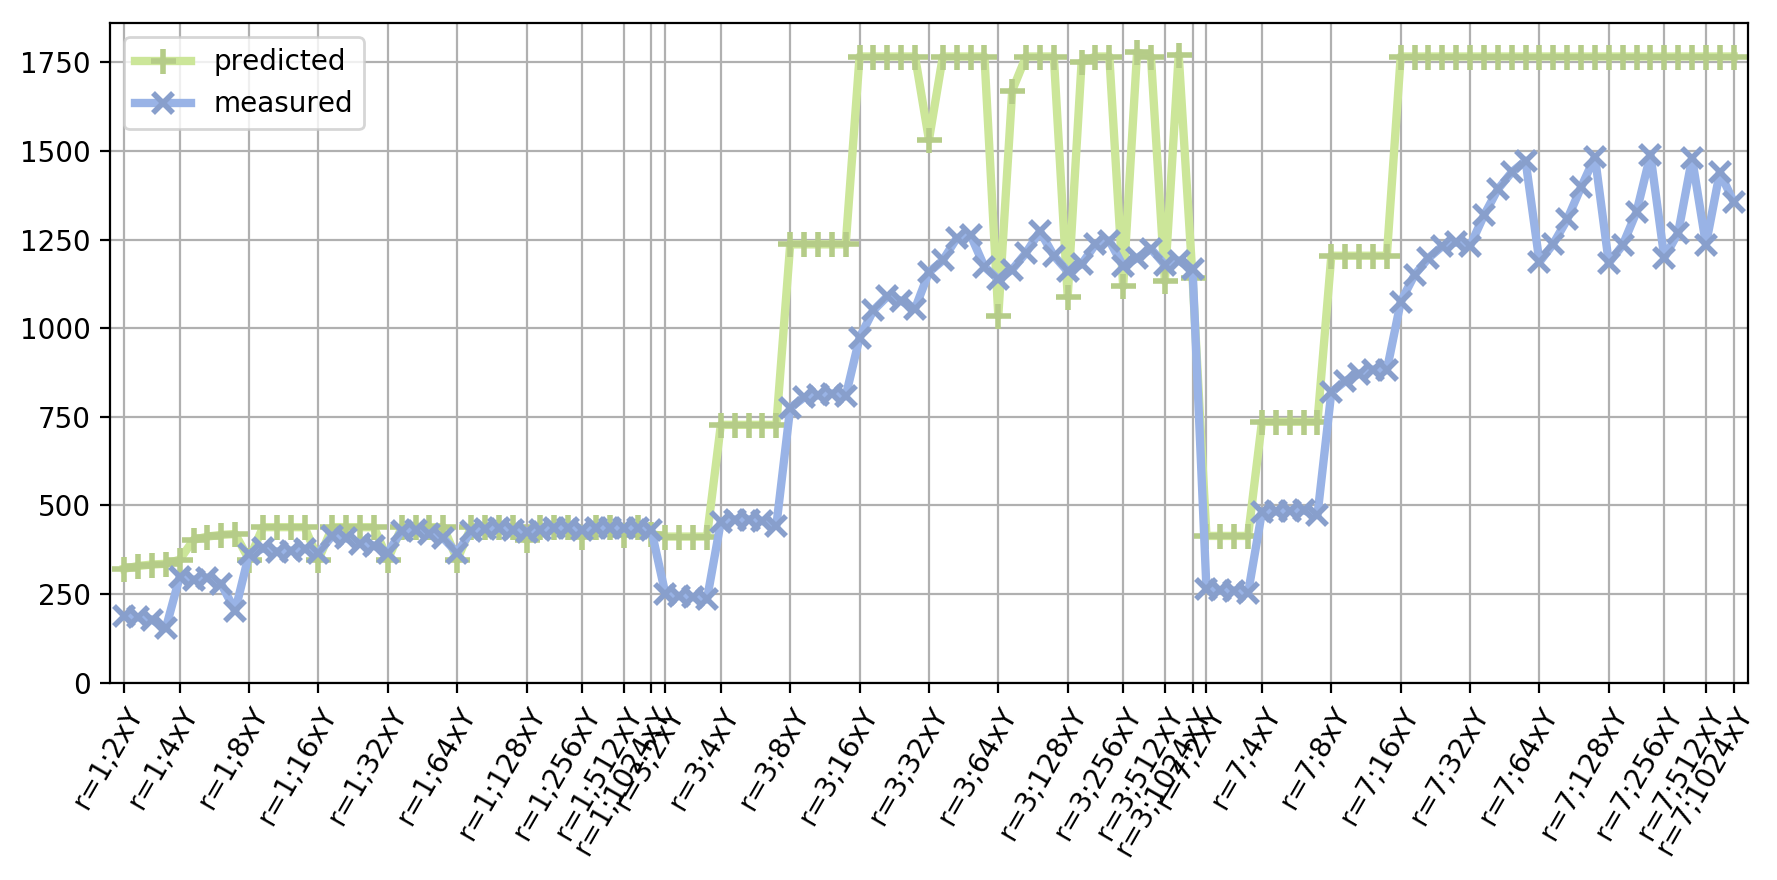

In [8]:
plotComparison(*memdata)